#### Notebook to create plots for doctoral thesis 

Coded in a way, that only first cell needs to be edited. Rest should be atomated.
Does calculations for a specific boundary condition and different parameter configurations: LFF and two MHS solutions. 
Need to edit:
- path to boundary condition data
- path to folder where plots are saved
- value choices for alpha and a


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield
from mhsflex.vis import plot, plot_plasma_parameters
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### For example from analytical expression

In [3]:
nresol_x = 200
nresol_y = 200
nresol_z = 400
xmin = 0.0
xmax = 20.0  # Mm
ymin = 0.0
ymax = 20.0
zmin = 0.0
zmax = 20.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

z0 = 2
deltaz = 0.2

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
B_PHOTO = 500
data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix] / 10.0
        y = y_arr[iy] / 10.0
        data_bz[iy, ix] = dalmatian(x, y) * B_PHOTO

data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nresol_x,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [ ]:
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels = np.array((-700, -400, -200, -100, 0, 100, 200, 400, 700)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=8, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plotname = "/Users/lilli/Desktop/Thesis/multipole_contour.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
from mhsflex.b3d import mirror

data_bz_see = mirror(data_bz)

In [ ]:
x_arr = np.arange(2 * nresol_x) * (2 * xmax) / (2 * nresol_x - 1) - xmax
y_arr = np.arange(2 * nresol_y) * (2 * ymax) / (2 * nresol_y - 1) - ymax

x_grid, y_grid = np.meshgrid(x_arr, y_arr)

fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data_bz_see,
    levels = np.array((-700, -400, -200, -100, 0, 100, 200, 400, 700)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.clabel(CS, fontsize=8, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plotname = "/Users/lilli/Desktop/Thesis/multipole_contour_seehafer.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

### SDO Example

In [ ]:
path = "/Users/lilli/Desktop/SOAR/obs/solo_L2_phi-hrt-blos_20220307T000609_V01.fits"
data2d = Field2dData.from_fits_SDO(path)

z0 = 2.0
deltaz = 0.2

### SOAR Example

In [ ]:
path = "/Users/lilli/Desktop/SOAR/obs/solo_L2_phi-hrt-blos_20220307T000609_V01.fits"
data2d = Field2dData.from_fits_SolOr(path)

z0 = 2.0
deltaz = 0.2

### Independent from here

In [ ]:
alpha = 0.05

length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * data2d.px 
length_scale_y = 2.0 * nresol_y * data2d.py 

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(data2d.nf) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(data2d.nf) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(data2d.nf) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2


# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - alpha ** 2) / (2 * k2_arr)

print(limit.min(), limit.argmin())

In [4]:
# Background atmosphere parameters
b = 1.0

alphapot = 0.0
alpha = 0.05

alff = 0.0
amhs1 = 0.22
amhs2 = 0.44

# data3d = calculate_magfield(data2d, amhs2, b, alpha, z0, deltaz)

In [ ]:
print(data3d.bz.max())
print(data3d.field[:, :, 0, 2].max())

In [ ]:
ix_max = np.unravel_index(data3d.bz.argmax(), data3d.bz.shape)[1]
iy_max = np.unravel_index(data3d.bz.argmax(), data3d.bz.shape)[0]

In [18]:
T_PHOTOSPHERE = 5600.0  # Photospheric temperature
T_CORONA = 2.0 * 10.0**6  # Coronal temperature

G_SOLAR = 272.2  # m/s^2
KB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
MBAR = 1.67262 * 10**-27  # mean molecular weight (proton mass)
RHO0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)
P0 = T_PHOTOSPHERE * KB * RHO0 / MBAR  # plasma pressure in kg/(s^2 m)
MU0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)

L = 10**6  # Lengthscale Mm
T0 = (T_PHOTOSPHERE + T_CORONA * np.tanh(data3dmhs1.z0 / data3dmhs1.deltaz)) / (
    1.0 + np.tanh(data3dmhs1.z0 / data3dmhs1.deltaz)
)
H = KB * T0 / (MBAR * G_SOLAR) / L
B0 = data3dmhs1.field[
    :, :, 0, 2
].max()  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
PB0 = (B0 * 10**-4) ** 2 / (
    2 * MU0
)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
BETA0 = P0 / PB0  # Plasma Beta, ration plasma to magnetic pressure

In [ ]:
plt.plot(
    data3d.z,
    -data3d.dpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
)
plt.plot(
    data3d.z,
    BETA0 / 2.0 * data3d.bpressure,
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
)
# plt.plot(
#     data3d.z,
#     data3d.fdensity[iy_max, ix_max, :],
#     linewidth=0.5,
#     linestyle="dashed",
#     color=c4,
# )
plt.xlabel("z")
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plt.show()

In [ ]:
plt.plot(
    data3d.z,
    -data3d.ddensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
)
plt.plot(
    data3d.z,
    BETA0 / (2.0 * H) * T0 / T_PHOTOSPHERE * data3d.bdensity,
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
)
# plt.plot(
#     data3d.z,
#     data3d.fdensity[iy_max, ix_max, :],
#     linewidth=0.5,
#     linestyle="dashed",
#     color=c4,
# )
plt.xlabel("z")
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plt.show()

In [ ]:
from mhsflex.field3d import btemp_linear, bdensity_linear, bpressure_linear
temps = np.array([6000.0, 5500.0, 10000.0, 2.0 * 10.0**6, 2.0 * 10.0**6])
heights = np.array([0.0, z0 / 4, z0, 4.0, 20.0])
templin = btemp_linear(data3d, heights, temps)

preslin = bpressure_linear(data3d, heights, temps)
denlin = bdensity_linear(data3d, heights, temps)

In [ ]:
from mhsflex.switch import f, dfdz

In [ ]:
fz = f(z_arr, z0, deltaz, amhs2, b)
dfz = dfdz(z_arr, z0, deltaz, amhs2, b)

In [ ]:
data3d_2F1 = calculate_magfield(data2d, amhs2, b, alpha, z0, deltaz, asymptotic=False)

In [ ]:
compare_field3d(data3d_2F1, data3d)

In [8]:
# Calculate magnetic field data
# data3dpot = calculate_magfield(data2d, alff, b, alphapot, z0, deltaz)
# data3dlff = calculate_magfield(data2d, alff, b, alpha, z0, deltaz)
# data3dmhs1 = calculate_magfield(data2d, amhs1, b, alpha, z0, deltaz)
data3dmhs2 = calculate_magfield(data2d, amhs2, b, alpha, z0, deltaz)

In [ ]:
path2saveP = "/Users/lilli/Desktop/mflex/multipole/P"
path2saveLFF = "/Users/lilli/Desktop/mflex/multipole/LFF"
path2saveMHS2 = "/Users/lilli/Desktop/mflex/multipole/MHS2"
path2saveMHS1 = "/Users/lilli/Desktop/mflex/multipole/MHS1"

# data3dpot.save(path2saveP)
# data3dlff.save(path2saveLFF)
# data3dmhs1.save(path2saveMHS1)
# data3dmhs2.save(path2saveMHS2)

In [ ]:
data3dpot = Field3dData.load(path2saveP)
data3dlff = Field3dData.load(path2saveLFF)
data3dmhs1 = Field3dData.load(path2saveMHS1)
data3dmhs2 = Field3dData.load(path2saveMHS2)

In [ ]:
folder = "/Users/lilli/Desktop/Thesis/multipole/plots"

In [ ]:
# contour plot

x_grid, y_grid = np.meshgrid(x_arr, y_arr)

fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-700, -400, -200, -100, 0, 100, 200, 400, 700)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=8, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/contour.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

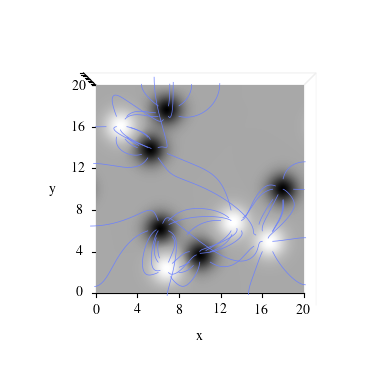

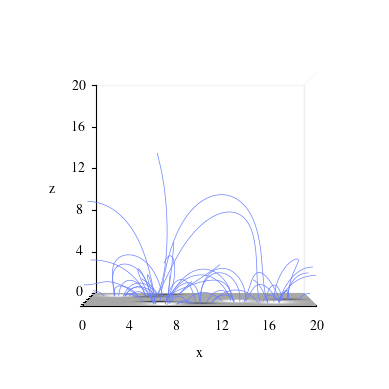

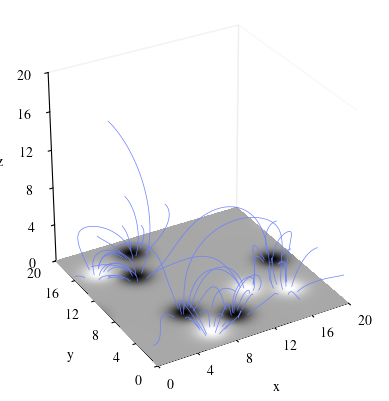

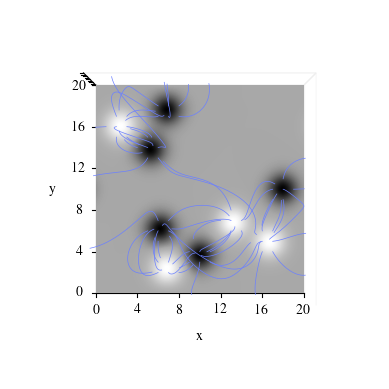

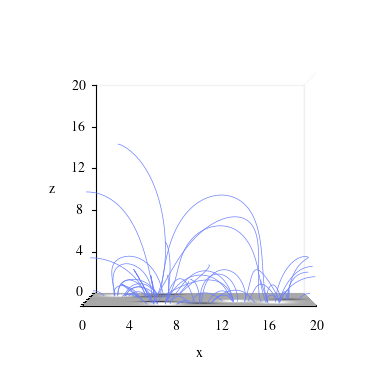

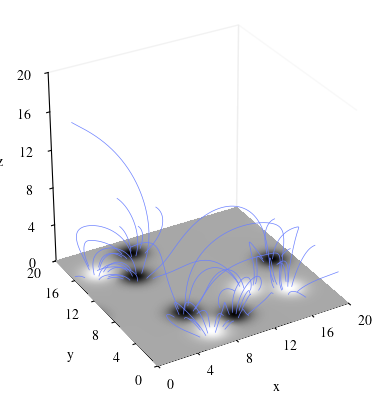

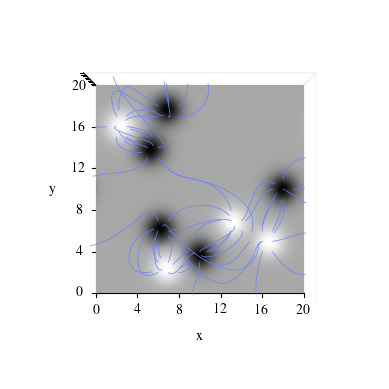

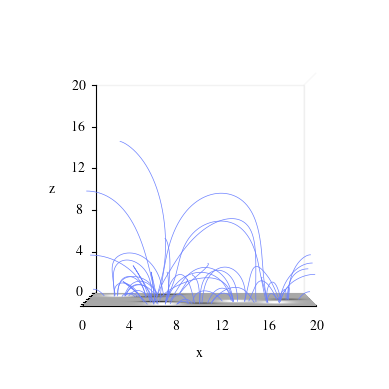

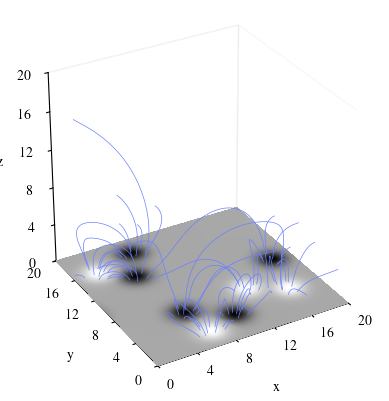

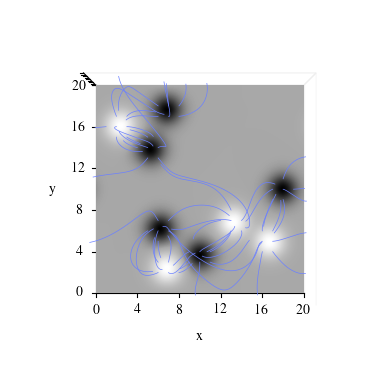

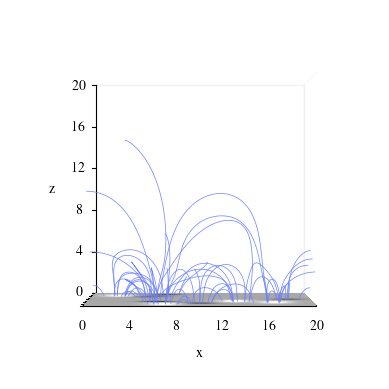

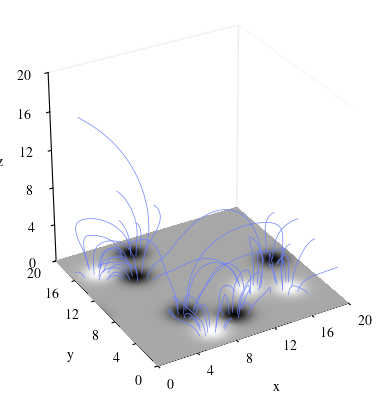

In [10]:
folder = "/Users/lilli/Desktop/Thesis/multipole/plots"

# Plot field lines

plot(data3dpot, "los", False, True, path=folder)
plot(data3dpot, "side", False, True, path=folder)
plot(data3dpot, "angular", False, True, path=folder)

plot(data3dlff, "los", False, True, path=folder)
plot(data3dlff, "side", False, True, path=folder)
plot(data3dlff, "angular", False, True, path=folder)

plot(data3dmhs1, "los", False, True, path=folder)
plot(data3dmhs1, "side", False, True, path=folder)
plot(data3dmhs1, "angular", False, True, path=folder)

plot(data3dmhs2, "los", False, True, path=folder)
plot(data3dmhs2, "side", False, True, path=folder)
plot(data3dmhs2, "angular", False, True, path=folder)

In [23]:
data3dpot_2F1 = calculate_magfield(
    data2d, alff, b, alphapot, z0, deltaz, asymptotic=False
)
data3dlff_2F1 = calculate_magfield(data2d, alff, b, alpha, z0, deltaz, asymptotic=False)
# data3dmhs1_2F1 = calculate_magfield(
#     data2d, amhs1, b, alpha, z0, deltaz, asymptotic=False
# )
# data3dmhs2_2F1 = calculate_magfield(
#     data2d, amhs2, b, alpha, z0, deltaz, asymptotic=False
# )

In [ ]:
path2saveP_2F1 = "/Users/lilli/Desktop/mflex/multipole/P_2F1"
path2saveLFF_2F1 = "/Users/lilli/Desktop/mflex/multipole/LFF_2F1"
path2saveMHS2_2F1 = "/Users/lilli/Desktop/mflex/multipole/MHS2_2F1"
path2saveMHS1_2F1 = "/Users/lilli/Desktop/mflex/multipole/MHS1_2F1"

data3dpot_2F1.save(path2saveP_2F1)
data3dlff_2F1.save(path2saveLFF_2F1)
data3dmhs1_2F1.save(path2saveMHS1_2F1)
data3dmhs2_2F1.save(path2saveMHS2_2F1)

In [12]:
folder2 = "/Users/lilli/Desktop/Thesis/multipole/plots_2F1"

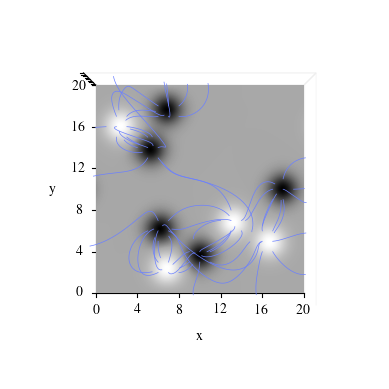

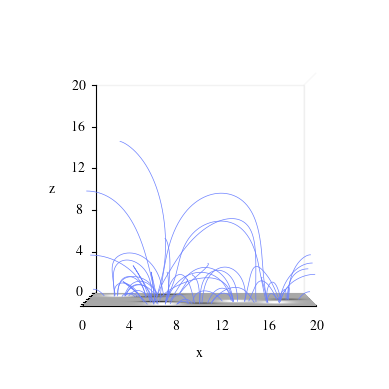

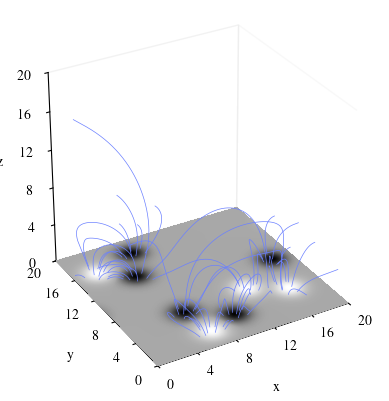

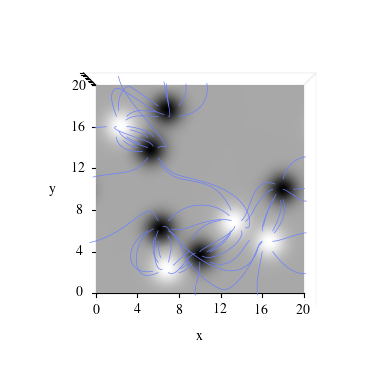

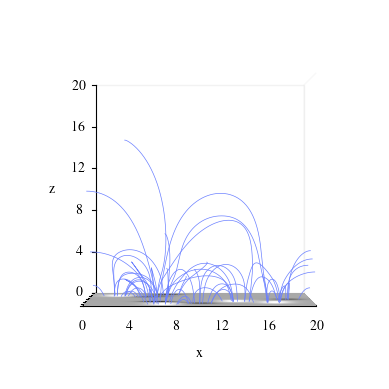

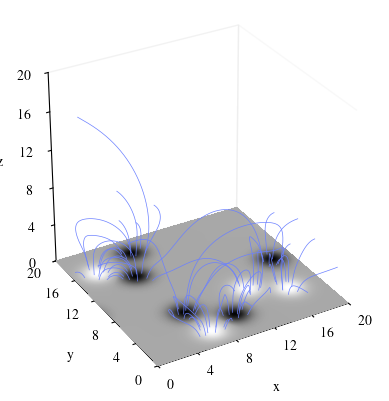

In [14]:
# plot(data3dpot_2F1, "los", False, True, path=folder2)
# plot(data3dpot_2F1, "side", False, True, path=folder2)
# plot(data3dpot_2F1, "angular", False, True, path=folder2)

# plot(data3dlff_2F1, "los", False, True, path=folder2)
# plot(data3dlff_2F1, "side", False, True, path=folder2)
# plot(data3dlff_2F1, "angular", False, True, path=folder2)

plot(data3dmhs1_2F1, "los", False, True, path=folder2)
plot(data3dmhs1_2F1, "side", False, True, path=folder2)
plot(data3dmhs1_2F1, "angular", False, True, path=folder2)

plot(data3dmhs2_2F1, "los", False, True, path=folder2)
plot(data3dmhs2_2F1, "side", False, True, path=folder2)
plot(data3dmhs2_2F1, "angular", False, True, path=folder2)

In [15]:
folder3 = "/Users/lilli/Desktop/Thesis/multipole"

In [ ]:
ix_max = np.unravel_index(data3dlff.bz.argmax(), data3dlff.bz.shape)[1]
iy_max = np.unravel_index(data3dlff.bz.argmax(), data3dlff.bz.shape)[0]

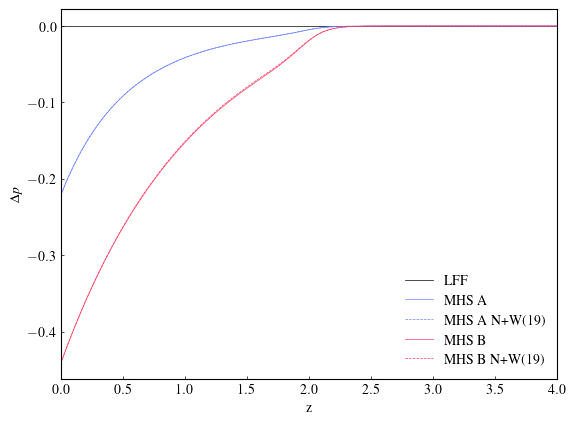

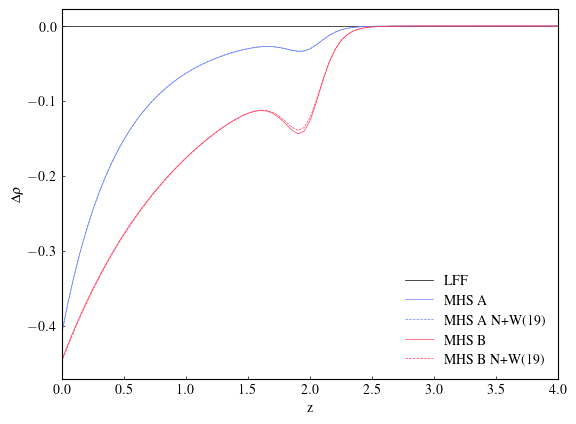

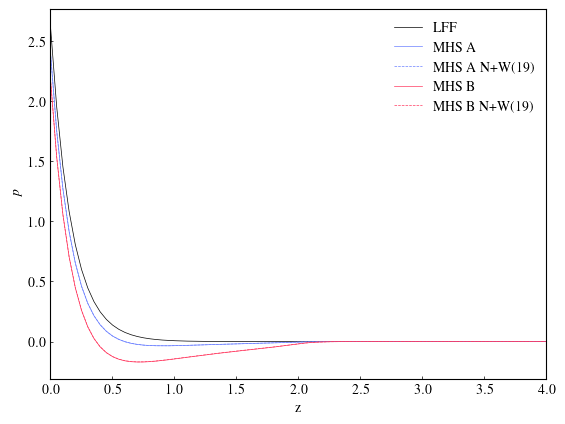

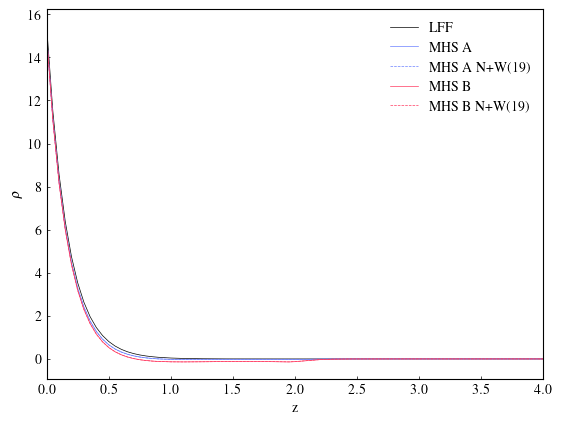

In [16]:
# Plot pressure and density where Bz is maximal on the photopshere

ix_max = np.unravel_index(data3dlff.bz.argmax(), data3dlff.bz.shape)[1]
iy_max = np.unravel_index(data3dlff.bz.argmax(), data3dlff.bz.shape)[0]

plt.plot(
    data3dlff.z,
    data3dlff.dpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label="LFF",
)
plt.plot(
    data3dmhs1.z,
    data3dmhs1.dpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label="MHS A",
)
plt.plot(
    data3dmhs1_2F1.z,
    data3dmhs1_2F1.dpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label="MHS A N+W(19)",
)
plt.plot(
    data3dmhs2.z,
    data3dmhs2.dpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label="MHS B",
)
plt.plot(
    data3dmhs2_2F1.z,
    data3dmhs2_2F1.dpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label="MHS B N+W(19)",
)
plt.ylabel(r"$\Delta p$")
plt.xlabel("z")
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder3 + "/dpres.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

plt.plot(
    data3dlff.z,
    data3dlff.ddensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label="LFF",
)
plt.plot(
    data3dmhs1.z,
    data3dmhs1.ddensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label="MHS A",
)
plt.plot(
    data3dmhs1_2F1.z,
    data3dmhs1_2F1.ddensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label="MHS A N+W(19)",
)
plt.plot(
    data3dmhs2.z,
    data3dmhs2.ddensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label="MHS B",
)
plt.plot(
    data3dmhs2_2F1.z,
    data3dmhs2_2F1.ddensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label="MHS B N+W(19)",
)
plt.ylabel(r"$\Delta \rho$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.xlim([0, 2 * z0])
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder3 + "/dden.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

plt.plot(
    data3dlff.z,
    data3dlff.fpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label="LFF",
)
plt.plot(
    data3dmhs1.z,
    data3dmhs1.fpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label="MHS A",
)
plt.plot(
    data3dmhs1_2F1.z,
    data3dmhs1_2F1.fpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label="MHS A N+W(19)",
)
plt.plot(
    data3dmhs2.z,
    data3dmhs2.fpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label="MHS B",
)
plt.plot(
    data3dmhs2_2F1.z,
    data3dmhs2_2F1.fpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label="MHS B N+W(19)",
)
plt.ylabel(r"$p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.xlim([0, 2 * z0])
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder3 + "/fpres.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

plt.plot(
    data3dlff.z,
    data3dlff.fdensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label="LFF",
)
plt.plot(
    data3dmhs1.z,
    data3dmhs1.fdensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label="MHS A",
)
plt.plot(
    data3dmhs1_2F1.z,
    data3dmhs1_2F1.fdensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label="MHS A N+W(19)",
)
plt.plot(
    data3dmhs2.z,
    data3dmhs2.fdensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label="MHS B",
)
plt.plot(
    data3dmhs2_2F1.z,
    data3dmhs2_2F1.fdensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label="MHS B N+W(19)",
)
plt.ylabel(r"$\rho$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.xlim([0, 2 * z0])
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder3 + "/fden.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

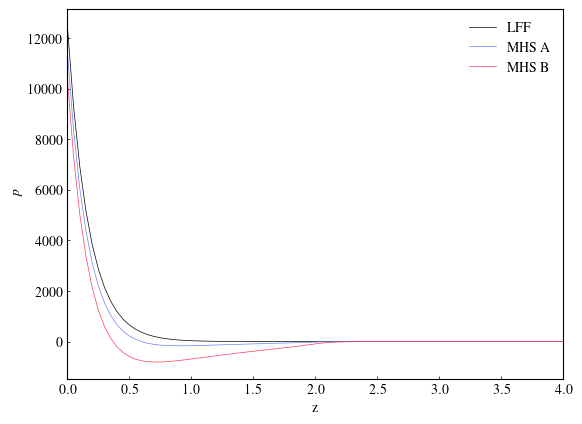

In [19]:
plt.plot(
    data3dlff.z,
    data3dlff.fpressure[iy_max, ix_max, :]* (B0 * 10**-4) ** 2.0 / MU0,
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label="LFF",
)
plt.plot(
    data3dmhs1.z,
    data3dmhs1.fpressure[iy_max, ix_max, :]* (B0 * 10**-4) ** 2.0 / MU0,
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label="MHS A",
)
plt.plot(
    data3dmhs2.z,
    data3dmhs2.fpressure[iy_max, ix_max, :]* (B0 * 10**-4) ** 2.0 / MU0,
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label="MHS B",
)
plt.ylabel(r"$p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.xlim([0, 2 * z0])
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fpres_SI.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

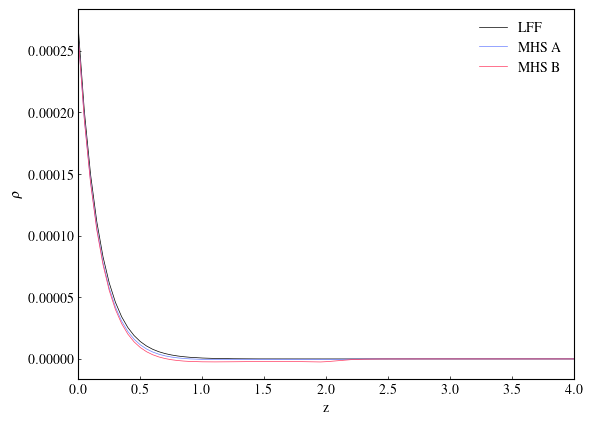

In [20]:
plt.plot(
    data3dlff.z,
    data3dlff.fdensity[iy_max, ix_max, :]*(B0 * 10**-4) ** 2.0 / (MU0 * G_SOLAR * L),
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label="LFF",
)
plt.plot(
    data3dmhs1.z,
    data3dmhs1.fdensity[iy_max, ix_max, :]*(B0 * 10**-4) ** 2.0 / (MU0 * G_SOLAR * L),
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label="MHS A",
)
plt.plot(
    data3dmhs2.z,
    data3dmhs2.fdensity[iy_max, ix_max, :]*(B0 * 10**-4) ** 2.0 / (MU0 * G_SOLAR * L),
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label="MHS B",
)
plt.ylabel(r"$\rho$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.xlim([0, 2 * z0])
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fden_SI.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

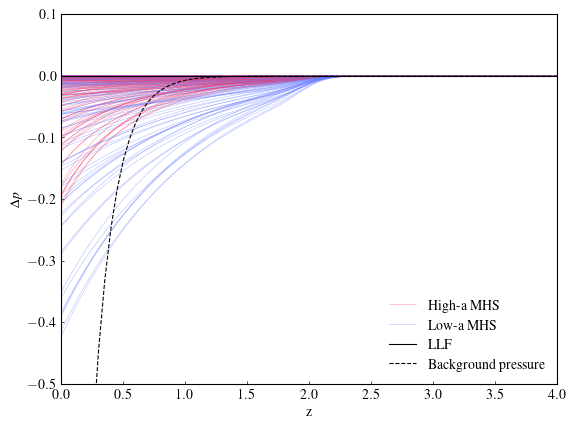

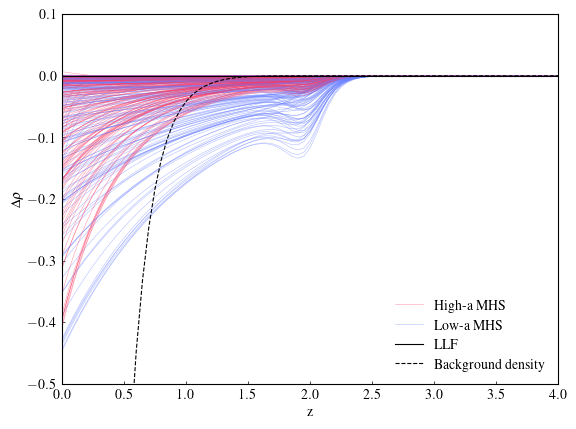

In [24]:
plt.plot(
    data3dmhs1_2F1.z,
    data3dmhs1_2F1.dpressure[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c4,
    alpha=0.5,
    label="High-a MHS",
)
plt.plot(
    data3dmhs1_2F1.z,
    data3dmhs2_2F1.dpressure[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c2,
    alpha=0.5,
    label="Low-a MHS",
)
for ix in range(0, data3dmhs1.nx, 12):
    for iy in range(0, data3dmhs1.ny, 12):
        plt.plot(
            data3dmhs1_2F1.z,
            data3dmhs1_2F1.dpressure[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c4,
            alpha=0.5,
        )
        plt.plot(
            data3dmhs1_2F1.z,
            data3dmhs2_2F1.dpressure[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c2,
            alpha=0.5,
        )
plt.plot(
    data3dmhs1.z,
    data3dlff_2F1.dpressure[0, 0, :],
    linewidth=0.8,
    linestyle="solid",
    color="black",
    label="LLF",
)
plt.plot(
    data3dmhs1_2F1.z,
    -BETA0 / 2.0 *data3dmhs2_2F1.bpressure,
    linewidth=0.8,
    linestyle="dashed",
    color=c3,
    label="Background pressure",
)
plt.xlim([0, 2 * z0])
plt.ylim([-0.5, 0.1])
plt.ylabel(r"$\Delta p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder2 + "/dpres.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()


plt.plot(
    data3dmhs1.z,
    data3dmhs1_2F1.ddensity[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c4,
    alpha=0.5,
    label="High-a MHS",
)
plt.plot(
    data3dmhs1.z,
    data3dmhs2_2F1.ddensity[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c2,
    alpha=0.5,
    label="Low-a MHS",
)
for ix in range(0, data3dmhs1.nx, 12):
    for iy in range(0, data3dmhs1.ny, 12):
        plt.plot(
            data3dmhs1.z,
            data3dmhs1_2F1.ddensity[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c4,
            alpha=0.5,
        )
        plt.plot(
            data3dmhs1.z,
            data3dmhs2_2F1.ddensity[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c2,
            alpha=0.5,
        )
plt.plot(
    data3dmhs1.z,
    data3dlff_2F1.ddensity[iy_max, ix_max, :],
    linewidth=0.8,
    linestyle="solid",
    color="black",
    label="LLF",
)
plt.plot(
    data3dmhs1_2F1.z,
    -BETA0 / (2.0 * H) * T0 / T_PHOTOSPHERE *data3dmhs2_2F1.bdensity,
    linewidth=0.8,
    linestyle="dashed",
    color="black",
    label="Background density",
)
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta \rho$")
plt.xlabel("z")
plt.ylim([-0.5, 0.1])
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder2 + "/dden.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

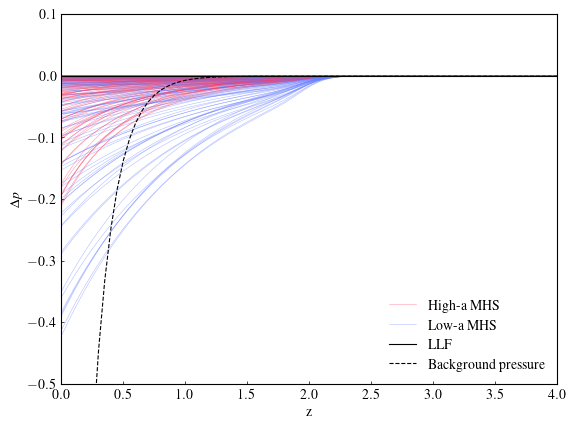

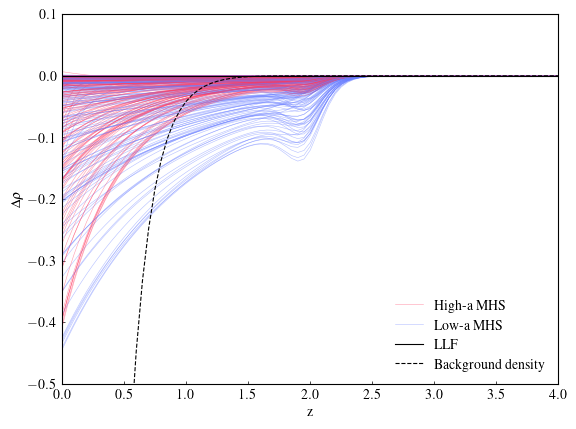

In [22]:
plt.plot(
    data3dmhs1.z,
    data3dmhs1.dpressure[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c4,
    alpha=0.5,
    label="High-a MHS",
)
plt.plot(
    data3dmhs1.z,
    data3dmhs2.dpressure[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c2,
    alpha=0.5,
    label="Low-a MHS",
)
for ix in range(0, data3dmhs1.nx, 12):
    for iy in range(0, data3dmhs1.ny, 12):
        plt.plot(
            data3dmhs1.z,
            data3dmhs1.dpressure[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c4,
            alpha=0.5,
        )
        plt.plot(
            data3dmhs1.z,
            data3dmhs2.dpressure[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c2,
            alpha=0.5,
        )
plt.plot(
    data3dmhs1.z,
    data3dlff.dpressure[0, 0, :],
    linewidth=0.8,
    linestyle="solid",
    color="black",
    label="LLF",
)
plt.plot(
    data3dmhs1.z,
    -BETA0 / 2.0 *data3dmhs2.bpressure,
    linewidth=0.8,
    linestyle="dashed",
    color=c3,
    label="Background pressure",
)
plt.xlim([0, 2 * z0])
plt.ylim([-0.5, 0.1])
plt.ylabel(r"$\Delta p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/dpres.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()


plt.plot(
    data3dmhs1.z,
    data3dmhs1.ddensity[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c4,
    alpha=0.5,
    label="High-a MHS",
)
plt.plot(
    data3dmhs1.z,
    data3dmhs2.ddensity[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c2,
    alpha=0.5,
    label="Low-a MHS",
)
for ix in range(0, data3dmhs1.nx, 12):
    for iy in range(0, data3dmhs1.ny, 12):
        plt.plot(
            data3dmhs1.z,
            data3dmhs1.ddensity[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c4,
            alpha=0.5,
        )
        plt.plot(
            data3dmhs1.z,
            data3dmhs2.ddensity[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c2,
            alpha=0.5,
        )
plt.plot(
    data3dmhs1.z,
    data3dlff.ddensity[iy_max, ix_max, :],
    linewidth=0.8,
    linestyle="solid",
    color="black",
    label="LLF",
)
plt.plot(
    data3dmhs1.z,
    -BETA0 / (2.0 * H) * T0 / T_PHOTOSPHERE *data3dmhs2.bdensity,
    linewidth=0.8,
    linestyle="dashed",
    color="black",
    label="Background density",
)
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta \rho$")
plt.xlabel("z")
plt.ylim([-0.5, 0.1])
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/dden.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

### Metric caluclation and plotting

In [25]:
deltaz_arr = np.array((0.1, 0.2, 0.4, 1.0))

data3dlff_d1 = calculate_magfield(data2d, alff, b, alpha, z0, 0.01)
data3dlff_2F1_d1 = calculate_magfield(
    data2d, alff, b, alpha, z0, 0.01, asymptotic=False
)

data3dlff_d2 = calculate_magfield(data2d, alff, b, alpha, z0, 0.02)
data3dlff_2F1_d2 = calculate_magfield(
    data2d, alff, b, alpha, z0, 0.02, asymptotic=False
)

data3dlff_d3 = calculate_magfield(data2d, alff, b, alpha, z0, 0.04)
data3dlff_2F1_d3 = calculate_magfield(
    data2d, alff, b, alpha, z0, 0.04, asymptotic=False
)

data3dlff_d4 = calculate_magfield(data2d, alff, b, alpha, z0, 0.1)
data3dlff_2F1_d4 = calculate_magfield(data2d, alff, b, alpha, z0, 0.1, asymptotic=False)

KeyboardInterrupt: 

In [ ]:
data3dmhs1_d1 = calculate_magfield(data2d, amhs1, b, alpha, z0, 0.1)
data3dmhs1_2F1_d1 = calculate_magfield(
    data2d, amhs1, b, alpha, z0, 0.1, asymptotic=False
)

data3dmhs1_d2 = calculate_magfield(data2d, amhs1, b, alpha, z0, 0.2)
data3dmhs1_2F1_d2 = calculate_magfield(
    data2d, amhs1, b, alpha, z0, 0.2, asymptotic=False
)

In [ ]:
data3dmhs1_d3 = calculate_magfield(data2d, amhs1, b, alpha, z0, 0.4)
data3dmhs1_2F1_d3 = calculate_magfield(
    data2d, amhs1, b, alpha, z0, 0.4, asymptotic=False
)

data3dmhs1_d4 = calculate_magfield(data2d, amhs1, b, alpha, z0, 1.0)
data3dmhs1_2F1_d4 = calculate_magfield(
    data2d, amhs1, b, alpha, z0, 1.0, asymptotic=False
)

In [ ]:
data3dmhs2_d1 = calculate_magfield(data2d, amhs2, b, alpha, z0, 0.1)
data3dmhs2_2F1_d1 = calculate_magfield(
    data2d, amhs2, b, alpha, z0, 0.1, asymptotic=False
)

data3dmhs2_d2 = calculate_magfield(data2d, amhs2, b, alpha, z0, 0.2)
data3dmhs2_2F1_d2 = calculate_magfield(
    data2d, amhs2, b, alpha, z0, 0.2, asymptotic=False
)

In [ ]:
data3dmhs2_d3 = calculate_magfield(data2d, amhs2, b, alpha, z0, 0.4)
data3dmhs2_2F1_d3 = calculate_magfield(
    data2d, amhs2, b, alpha, z0, 0.4, asymptotic=False
)

data3dmhs2_d4 = calculate_magfield(data2d, amhs2, b, alpha, z0, 1.0)
data3dmhs2_2F1_d4 = calculate_magfield(
    data2d, amhs2, b, alpha, z0, 1.0, asymptotic=False
)

### LFF

In [ ]:
print("Delta z 1")
compare_field3d(data3dlff_2F1_d1, data3dlff_d1)

print("Delta z 2")
compare_field3d(data3dlff_2F1_d2, data3dlff_d2)

print("Delta z 3")
compare_field3d(data3dlff_2F1_d3, data3dlff_d3)

print("Delta z 4")
compare_field3d(data3dlff_2F1_d4, data3dlff_d4)

### MHS 1

In [ ]:
print("Delta z 1")
compare_field3d(
    data3dmhs1_2F1_d1, data3dmhs1_d1
)

print("Delta z 2")
compare_field3d(
    data3dmhs1_2F1_d2, data3dmhs1_d2
)

print("Delta z 3")
compare_field3d(
    data3dmhs1_2F1_d3, data3dmhs1_d3
)

print("Delta z 4")
compare_field3d(
    data3dmhs1_2F1_d4, data3dmhs1_d4
)

### MHS 2

In [ ]:
print("Delta z 1")
compare_field3d(data3dmhs2_2F1_d1, data3dmhs2_d1)

print("Delta z 2")
compare_field3d(data3dmhs2_2F1_d2, data3dmhs2_d2)

print("Delta z 3")
compare_field3d(data3dmhs2_2F1_d3, data3dmhs2_d3)

print("Delta z 4")
compare_field3d(data3dmhs2_2F1_d4, data3dmhs2_d4)

In [ ]:
deltaz_arr = np.array((0.1, 0.2, 0.4, 1.0))

VC_arr_mhs1 = np.array((0.999999774272, 0.999998234568, 0.999985683109, 0.999812833596))

CS_arr_mhs1 = np.array((0.999999966466, 0.999999758093, 0.999998289427, 0.999982492663))

VC_arr_mhs2 = np.array((0.999997982261, 0.999982704403, 0.99985030789, 0.998175619955))

CS_arr_mhs2 = np.array((0.999999839970, 0.999998673765, 0.999989079442, 0.999882477633))

MagEn_arr_mhs2 = np.array((1.000640366180, 1.002408129390, 1.008643495234, 1.034597151323))

MagEn_arr_mhs1 = np.array((1.000065600687, 1.000245603162, 1.000914788544, 1.004008275998))

NErr_arr_mhs1 = np.array((0.000306689418, 0.001105940676, 0.003777385969, 0.015465718540))

MErr_arr_mhs1 = np.array((0.000101410015, 0.000377410160, 0.001363735034, 0.006840369687))

NErr_arr_mhs2 = np.array((0.000979698582, 0.003512575936, 0.011752620456, 0.044781677146))

MErr_arr_mhs2 = np.array((0.000255897399, 0.000940694147, 0.003307214415, 0.015504780034))

In [ ]:
c5 = (1.000, 0.000, 0.773)


c6 = (1.000, 0.780, 0.000)
c7 = (0.443, 1.000, 0.855)
c8 = (0.996, 1.000, 0.000)

c9 = (0.671, 0.714, 1.000)

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(
    deltaz_arr,
    VC_arr_mhs1,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=c1,
    label="VecCorr l-a",
)
ax1.plot(
    deltaz_arr,
    VC_arr_mhs2,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=(0.000, 0.365, 0.580),
    label="VecCorr h-a",
)

ax1.plot(
    deltaz_arr,
    CS_arr_mhs1,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=(1.000, 0.533, 0.627),
    label="CSchw l-a",
)
ax1.plot(
    deltaz_arr,
    CS_arr_mhs2,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=c4,
    label="CSchw h-a",
)


ax1.set_ylabel("VecCorr, CSchw")

ax1.set_xlabel(r"$\Delta z$")

ax2 = ax1.twinx()

ax2.plot(
    deltaz_arr,
    MErr_arr_mhs1,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=(1.000, 0.831, 0.514),
    label="MErr l-a",
)
ax2.plot(
    deltaz_arr,
    MErr_arr_mhs2,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=(1.000, 0.537, 0.000),
    label="MErr h-a",
)

ax2.set_ylabel("MErr")

ax3 = ax1.twinx()

ax3.plot(
    deltaz_arr,
    MagEn_arr_mhs1,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=(1.000, 0.514, 0.890),
    label="MagEn l-a",
)
ax3.plot(
    deltaz_arr,
    MagEn_arr_mhs2,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=c5,
    label="MagEn h-a",
)
ax3.spines["right"].set_position(("outward", 50))

ax4 = ax1.twinx()

ax4.plot(
    deltaz_arr,
    NErr_arr_mhs1,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=c9,
    label="NErr l-a",
)
ax4.plot(
    deltaz_arr,
    NErr_arr_mhs2,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=c2,
    label="NErr h-a",
)
ax4.spines["right"].set_position(("outward", 100))

ax4.set_ylabel("NErr")

ax3.set_ylabel("MagEn")
# ax1.legend(frameon=False, loc='center left', bbox_to_anchor=(1.1, 0.8))
# ax2.legend(frameon=False, loc ='center left', bbox_to_anchor=(1.1, 0.55))
# ax3.legend(frameon=False, loc ='center left', bbox_to_anchor=(1.1, 0.35))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
lines = lines1 + lines2 + lines3 + lines4
labels = labels1 + labels2 + labels3 + labels4
plt.legend(lines, labels, frameon=False, loc="center left", bbox_to_anchor=(1.37, 0.5))

ax1.tick_params(direction="in", length=2, width=0.5)
ax2.tick_params(direction="in", length=2, width=0.5)
ax3.tick_params(direction="in", length=2, width=0.5)
ax4.tick_params(direction="in", length=2, width=0.5)
plotname = folder3 + "/metrics.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()